In [1]:
# импортируем библиотеки
import pathlib
import tensorflow as tf
# задаём путь до директории с тренировочным сетом данных
data_dir = 'D://cards/train'
data_dir = pathlib.Path(data_dir)
# посчитаем количество снимков 
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10629


In [2]:
# зададим переменные, которые понадобятся нам в дальнейшем - размер одной порции данных для обучения сети и разрешение
batch_size = 32
img_height = 116
img_width = 116
# делим датасет на тренировочный и валидационный в отношении 80 на 20%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=32,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
# задаём переменную имени классов и смотрим в каком количестве какие классы представлены
class_names = train_ds.class_names
print(class_names)

Found 10629 files belonging to 2 classes.
Using 8504 files for training.
Found 10629 files belonging to 2 classes.
Using 2125 files for validation.
['no', 'yes']


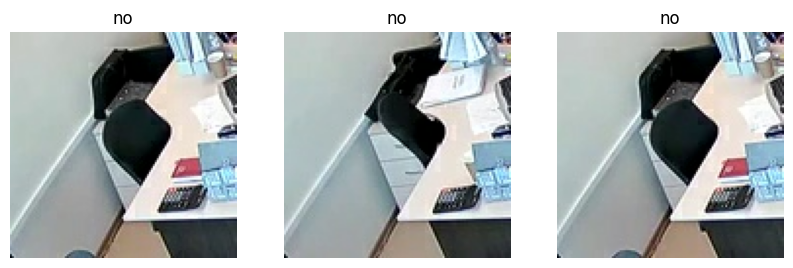

In [3]:
# импортируем библиотеку для отрисовки изображений, отрисуем несколько кадров с названием класса над ними
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
# посомтрим на количество кадров в одном батче(порции), размерность изображений, канальность, форму данных класса
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
# 32 штуки в батче, 116х116 - разрешение, 3 - каналы RGB

(32, 116, 116, 3)
(32,)


In [8]:
# данные строки кода была в документация, как крайне рекомендуемая то ли для улучшения производительности, то ли для 
# снижения вероятности переобучения
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# импорт библиотек для построения архитектуры нейросети
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D 
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import warnings

In [28]:
# задаём модель, последовательные слои: первый - рескейлинг (приводит значения цветов пикселей RGB из диапазона
# от 0 до 255 в диапазон от 0 до 1, так нейросеть лучше обучается)
# затем слои самих нейронов с параметрами, батч-нормализация после слоя нейронов, макс пулинг. И по кругу
# дропаут слои для отключения части нейронов (снижаем вероят. переобучения)
# ласт слой с 2 нейронами и функцией софтмакс, так как у нас всего 2 класса на выходе (1 или 0)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001),
                 activation='relu'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001),
                 activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2), strides=2),
  
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.25),  
    
  tf.keras.layers.Dense(2, kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.0001), activation='softmax')
])

In [29]:
# компилируем модель, задаём критерий потерь, оптимизатор и метрику оценки точности нейросети
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [30]:
# заполняем модель данными и ждём....10 эпох...
# ...долго ждём.
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)


Epoch 1/10
266/266 [==============================] - 273s 1s/step - loss: 0.0537 - accuracy: 0.9967 - val_loss: 0.0432 - val_accuracy: 1.0000
Epoch 2/10
266/266 [==============================] - 254s 954ms/step - loss: 0.0349 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 3/10
266/266 [==============================] - 257s 967ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 4/10
266/266 [==============================] - 261s 982ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 5/10
266/266 [==============================] - 259s 974ms/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 6/10
266/266 [==============================] - 259s 973ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 7/10
266/266 [==============================] - 256s 963ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0117 - va

In [23]:
пытался прикрутить имэдж генератор, для большего разнообразия изображений, но для этого нужно немного по-другому 
структурировать датасет
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         width_shift_range=0.1, 
#         height_shift_range=0.1) 
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         train_ds,
#         target_size=(116, 116),
#         batch_size=32,
#         class_mode='binary')
# validation_generator = test_datagen.flow_from_directory(
#         val_ds,
#         target_size=(116, 116),
#         batch_size=32,
#         class_mode='binary')
# model.fit(
#         train_generator,
#         steps_per_epoch=len(train_generator),
#         epochs=10,
#         validation_data=validation_generator,
#         validation_steps=800)

# datagen = ImageDataGenerator(
#         width_shift_range=0.1, 
#         height_shift_range=0.1) 
# datagen.fit(train_ds) 
# iterator = datagen.flow(train_ds, val_ds,
#                         batch_size=64)
# model.fit(iterator, steps_per_epoch=len(iterator),
#                         epochs=10)

TypeError: float() argument must be a string or a real number, not 'PrefetchDataset'

In [31]:
# оцениваем модель на валидационном сете
# точность 100%...пока не о чем не говорит, ведь этот сет также применялся в обучении
model.evaluate(val_ds)

67/67 [==============================] - 16s 234ms/step - loss: 0.0065 - accuracy: 1.0000


[0.00648232689127326, 1.0]

In [33]:
# просто выводим предсказание рандомного кадра
model.predict(val_ds)[888].round()

67/67 [==============================] - 16s 235ms/step


array([1., 0.], dtype=float32)

In [50]:
# из тестовой папки (нейросеть не видела эти изображения) получаем число изображений на которых будем определять точность 
# предсказания сети
test_dir = 'D://cards/test'
test_dir = pathlib.Path(test_dir)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print(image_count_test)

648


In [51]:
# как и в начале, формируем тестовый сет из изображений с помощью метода from_directory
val_ds_test = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 648 files belonging to 2 classes.
Using 129 files for validation.


In [53]:
# выводим классы тестового сета
class_names_test = val_ds_test.class_names
print(class_names_test)

['no', 'yes']


In [54]:
# оцениваем методом .evaluate модель, загнав в неё тестовый сет
model.evaluate(val_ds_test)

5/5 [==============================] - 1s 189ms/step - loss: 0.0065 - accuracy: 1.0000


[0.006481579504907131, 1.0]

In [47]:
# получили низкий лосс(потери) и точность 100%
# вообще, не люблю точность 100%, так как это, возможно, свидетельствует о переобученности нейросети. Она научилась
# хорошо определять наличие именно этой девушки в розовом свитере, но может не определить мужчину в чёрном пиджаке.
# как бы то ни было, часть задания выполнена, сохраняем модель Keras в нужную директорию методом .save
model.save('D://cards/')

INFO:tensorflow:Assets written to: D://cards/assets


INFO:tensorflow:Assets written to: D://cards/assets


In [48]:
# попытка загрузить модель
model_1 = keras.models.load_model('D://cards/')